# 02 Camera and ray - Multi-process

* 기존 예제에서 for loop을 제거하고 multi-process를 적용하여 가속하는 예제입니다.
    * 파이썬의 반복문은 컴파일 언어에 비교하면 매우 느립니다.
    * 이후의 실습들을 위해 미리 가속합니다.
* multiprocessing은 notebook에 정의된 함수를 사용할 수 없기 때문에 py 파일에 정의하고 import 합니다.

In [1]:
import multiprocessing as mp
from functools import partial

import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

from _02_camera_and_ray import compute_ray_color

### Multi-threading vs Muti-processing

* process
    * 실행 중인 프로그램의 인스턴스
    * 프로세스는 독립적인 메모리 공간을 가지고 있습니다.
        * 서로 다른 프로세스 사이에는 IPC(Inter-Process Communication)를 통해 데이터를 주고 받습니다.
* Thread
    * 프로세스 내에서 실행되는 작업 단위
    * 동일한 프로세스 내의 스레드들은 프로세스의 메모리 공간을 공유합니다.
* 프로세스들 간의 컨텍스트 스위칭은 스레드들 간의 컨텍스트 스위칭 보다 오버헤드가 큽니다.
* 프로세스는 각각 독립적으로 실행되고 종료, 스레드는 부모 프로세스가 실행되는 동안 실행되고 종료됩니다.

### GIL(Global Interpreter Lock)

* 파이썬에서는 한 번에 하나의 스레드만 바이트코드를 실행할 수 있습니다.
    * 메모리 관리를 위해 쉬운 길을 선택한 결과입니다.
    * 파이썬은 Garbage Collection(GC)을 위해 오브젝트의 참조 회수를 카운트 하는데 여러 바이트코드가 한번에 실행되면 GC가 제대로 돌아가지 않을 수 있기 때문입니다.
* 2023년에 파이썬에서 GIL을 제거하기로 결정했고 파이썬 3.13 버전부터 GIL을 비활성화 할수 있게 되었습니다.
    * https://docs.python.org/3.13/whatsnew/3.13.html#free-threaded-cpython

<img src="./images/python_gil.png" width="600px" title="python gil"/>
    
### Muti-processing

* 이 실습에서는 멀티 프로세싱으로 구현합니다.
* 이미지의 각 픽셀에 해당하는 프로세스를 생성하고 각 프로세스가 해당 픽셀의 색상을 계산하도록 합니다.

In [2]:
# image
aspect_ratio = 16.0 / 9.0
image_width = 320
image_height = int(image_width / aspect_ratio)

In [3]:
# camera
viewport_height = 2.0
viewport_width = aspect_ratio * viewport_height
focal_length = 1.0

camera_origin = np.array([0.0, 0.0, 0.0])
horizontal_vec = np.array([viewport_width, 0.0, 0.0])
vertical_vec = np.array([0.0, viewport_height, 0.0])
backward_vec = np.array([0.0, 0.0, focal_length])
lower_left_corner = (
    camera_origin - horizontal_vec / 2.0 - vertical_vec / 2.0 - backward_vec
)

각 프로세스의 입력은 공통 파라미터 외에 픽셀의 UV 좌표계가 입력으로 들어갑니다.
* 프로세스 실행 전에 각 픽셀의 UV 좌표계를 생성합니다.

In [4]:
uv_list = []
for row in range(image_height):
    for col in range(image_width):
        u = float(col) / (image_width - 1)
        v = float(row) / (image_height - 1)
        uv_list.append((u, v))

* partial은 함수의 인수들 중에 하나 이상의 인수를 미리 채워놓은 함수를 만들때 사용합니다.
* mp.Pool을 이용해서 process의 pool을 생성합니다.
    * processes는 생성된 process의 개수를 의미합니다. 현재 시스템의 CPU의 코어 개수로 설정하면 적당합니다.
    * pool.map 함수를 통해 compute_ray_color_func 함수와 미리 생성해둔 uv_list의 값들을 맵핑합니다.
    * pool.close를 통해 작업들이 pool에 제출되지 않도록 하고, pool.join으로 pool의 모든 프로세스가 종료되기를 기다립니다.
* output_list를 numpy array로 변경하고 이미지의 형태로 reshape 합니다. 

In [5]:
%%time

compute_ray_color_func = partial(
    compute_ray_color, 
    camera_origin=camera_origin, 
    horizontal_vec=horizontal_vec, 
    vertical_vec=vertical_vec, 
    lower_left_corner=lower_left_corner)

with mp.Pool(processes=4) as pool:
    output_list = pool.map(func=compute_ray_color_func, iterable=uv_list)
    pool.close()
    pool.join()

image = np.array(output_list).reshape(image_height, image_width, 3)

CPU times: total: 141 ms
Wall time: 516 ms


multi-process를 사용하지 않은 이전 구현과 동일한 결과가 나왔다면 제대로 구현된 겁니다.

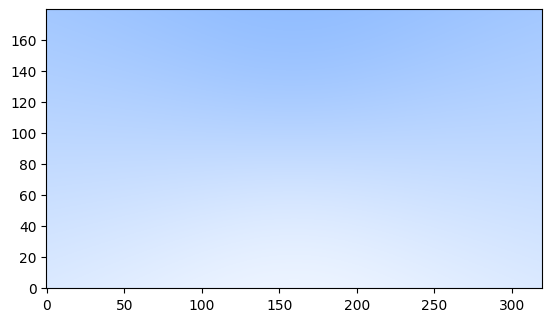

In [6]:
plt.imshow(image, origin='lower')
plt.show()